<a href="https://colab.research.google.com/github/RakeshSharma21/Sessions_Notebook/blob/main/Naive_bayes_and_Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install pandas

In [3]:
!pip install scikit-learn
!pip install matplotlib

**Overview:** This notebook aims to give you a brief overview of performing text classification using Naive Bayes, Logistic Regression and Support Vector Machines. We will be using a dataset called "Economic news article tone and relevance" from [Figure-Eight](https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/Data/Full-Economic-News-DFE-839861.csv) which consists of approximately 8000 news articles, which were tagged as relevant or not relevant to the US Economy. Our goal in this notebook is to explore the process of training and testing text classifiers for this problem, using this data set and two text classification algorithms: Multinomial Naive Bayes and Logistic Regression, implemented in sklearn.

##### Dataset Link: In the a folder called Data in folder Ch4 of this repo
<br><br>
Let's import few necessary packages before we start our work

In [113]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd # to work with csv files

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words


# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

In [114]:
try:
    from google.colab import files
    !wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
    !ls -lah DATAPATH
    our_data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

except ModuleNotFoundError:
    our_data = pd.read_csv("Data/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )

--2023-08-26 10:35:47--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [text/plain]
Saving to: ‘DATAPATH/Full-Economic-News-DFE-839861.csv.2’

Full-Economic-News- 100%[===================>]  11.81M  --.-KB/s    in 0.03s   

2023-08-26 10:35:47 (395 MB/s) - ‘DATAPATH/Full-Economic-News-DFE-839861.csv.2’ saved [12383529/12383529]

total 36M
drwxr-xr-x 2 root root 4.0K Aug 26 10:35 .
drwxr-xr-x 1 root root 4.0K Aug 26 05:47 ..
-rw-r--r-- 1 root root  12M Aug 26 05:47 Full-Economic-News-DFE-839861.csv
-rw-r--r-- 1 root root  12M Aug 26 08:10 Full-Economic-News-DFE-839861.csv.1
-rw-r--r-- 1 root root  12M Aug 26 10:35 Full-Economic-News

In [115]:
display(our_data.shape) # Number of rows (instances) and columns in the dataset
our_data["relevance"].value_counts()/our_data.shape[0] # Class distribution in the dataset

(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

In [116]:
our_data[['text','relevance']].head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,yes
1,The Wall Street Journal Online</br></br>The Mo...,no
2,WASHINGTON -- In an effort to achieve banking ...,no
3,The statistics on the enormous costs of employ...,no
4,NEW YORK -- Indecision marked the dollar's ton...,yes


In [117]:
our_data[['text','relevance']]['text'][0]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

In [118]:
# convert label to a numerical variable
our_data = our_data[our_data.relevance != "not sure"] # removing the data where we don't want relevance="not sure".
our_data.shape
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0.
our_data = our_data[["text","relevance"]] # Let us take only the two columns we need.
our_data.shape

(7991, 2)

In [119]:
our_data=our_data.reset_index()

### Section 2: Text Pre-processing

Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed. Here, we are performing the following steps: removing br tags, punctuation, numbers, and stopwords. While we are using sklearn's list of stopwords, there are several other stop word lists (e.g., from NLTK) or sometimes, custom stopword lists are needed depending on the task.

In [120]:
stopwords = stop_words
def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    # remove punctuation and numbers
    return doc

### Section 3: Modeling

Now we are ready for the modelling. We are going to use algorithms from sklearn package. We will go through the following steps:

1 Split the data into training and test sets (75% train, 25% test)    
2 Extract features from the training data using CountVectorizer, which is a bag of words feature  implementation. We will use the pre-processing function above in conjunction with Count Vectorizer  
3 Transform the test data into the same feature vector as the training data.  
4 Train the classifier  
5 Evaluate the classifier  

In [121]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: train-test split
X = our_data.text # the column text contains textual data to extract features from
y = our_data.relevance # this is the column we are learning to predict.
print(X.shape, y.shape)
# split X and y into training and testing sets. By default, it splits 75% training and 25% test
# random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [122]:
X_train

2999    International Business Machines Corp. reported...
2000    WASHINGTON--Sales of new homes surged in June ...
486     Corrections & Amplifications</br></br>SOLECTRO...
5420    Excerpts from "the first rough draft of histor...
440     Jittery investors pinned their hopes on consum...
                              ...                        
7935    The stock market, jolted 'back, into motion by...
5192    Stockholders of Dan River Inc. voted yesterday...
3980    The "bond vigilantes" who once imposed law and...
235     After five years on Easy Street, investors are...
5157    A fight is shaping up in Congress over whether...
Name: text, Length: 5993, dtype: object

In [123]:
# Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) # instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)# use it to extract features from training data
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)
# i.e., the dimension of our feature vector is 49753!

(5993, 49753) (1998, 49753)


In [126]:
#vect.vocabulary_
#vect.vocabulary_.keys()

#### Using Mulitnomial naive bayes

In [127]:
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) #

CPU times: user 7.35 ms, sys: 17 µs, total: 7.37 ms
Wall time: 7.41 ms


Accuracy:  0.7822822822822822
ROC_AOC_Score:  0.7251117679464362


<Figure size 800x600 with 0 Axes>

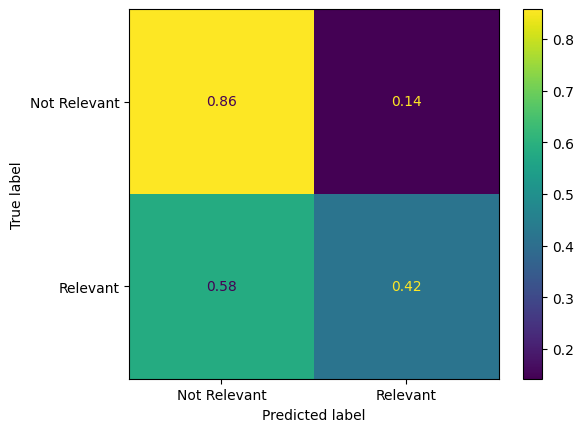

In [129]:
import itertools
from sklearn.metrics import roc_auc_score
# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))


# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(cm, display_labels=['Not Relevant','Relevant'])

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))
disp.plot()
plt.show()

In [130]:
from sklearn.model_selection import StratifiedKFold

In [131]:
vect = CountVectorizer(preprocessor=clean) # instantiate a vectoriezer
X_kf = vect.fit_transform(X)# use it to extract features from training data
# transform testing data (using training data's features)
print(X_kf.shape)

(7991, 57775)


In [133]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
nb_accu_stratified = []

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X_kf[train_index], X_kf[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    nb.fit(x_train_fold, y_train_fold)
    y_pred_prob = nb.predict_proba(x_test_fold)[:, 1]
    nb_accu_stratified.append(roc_auc_score(y_test_fold, y_pred_prob))

In [134]:
nb_accu_stratified

[0.73597038504793,
 0.7211396231268892,
 0.7258290994061783,
 0.7502545715694471,
 0.6906968829721096]

In [135]:
# Print the output.
import statistics
print('List of possible accuracy:', nb_accu_stratified)
print('\nMaximum ROC That can be obtained from this model is:',
      max(nb_accu_stratified)*100, '%')
print('\nMinimum ROC:',
      min(nb_accu_stratified)*100, '%')
print('\nOverall ROC:',
      np.mean(nb_accu_stratified)*100, '%')
print('\nStandard Deviation is:', statistics.stdev(nb_accu_stratified))

List of possible accuracy: [0.73597038504793, 0.7211396231268892, 0.7258290994061783, 0.7502545715694471, 0.6906968829721096]

Maximum ROC That can be obtained from this model is: 75.02545715694471 %

Minimum ROC: 69.06968829721096 %

Overall ROC: 72.47781124245108 %

Standard Deviation is: 0.022080479591894655


At this point, we can notice that the classifier is doing poorly with identifying relevant articles, while it is doing well with non-relevant ones. Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. Let us change the count vectorizer to take a certain number of features as maximum.

CPU times: user 4.52 ms, sys: 0 ns, total: 4.52 ms
Wall time: 4.53 ms
Accuracy:  0.6876876876876877
ROC_AOC_Score:  0.7282608695652173


<Figure size 800x600 with 0 Axes>

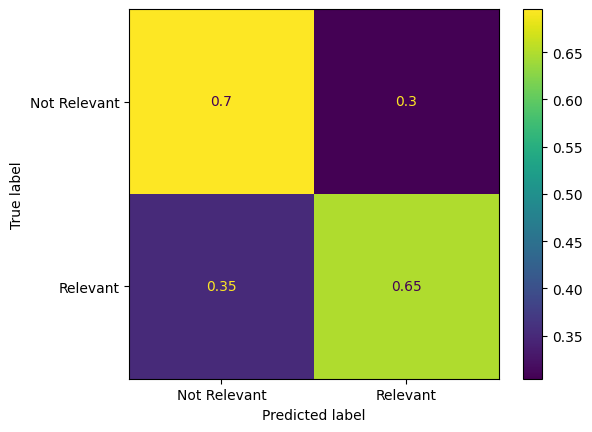

In [136]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))

disp = ConfusionMatrixDisplay(cm, display_labels=['Not Relevant','Relevant'])

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))
disp.plot()
plt.show()


In [137]:
vect = CountVectorizer(preprocessor=clean, max_features=5000) # instantiate a vectoriezer
X_kf = vect.fit_transform(X)# use it to extract features from training data
# transform testing data (using training data's features)
print(X_kf.shape)

(7991, 5000)


In [138]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
nb_accu_stratified = []

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X_kf[train_index], X_kf[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    nb.fit(x_train_fold, y_train_fold)
    y_pred_prob = nb.predict_proba(x_test_fold)[:, 1]
    nb_accu_stratified.append(roc_auc_score(y_test_fold, y_pred_prob))

In [139]:
# Print the output.
import statistics
print('List of possible accuracy:', nb_accu_stratified)
print('\nMaximum ROC That can be obtained from this model is:',
      max(nb_accu_stratified)*100, '%')
print('\nMinimum ROC:',
      min(nb_accu_stratified)*100, '%')
print('\nOverall ROC:',
      np.mean(nb_accu_stratified)*100, '%')
print('\nStandard Deviation is:', statistics.stdev(nb_accu_stratified))

List of possible accuracy: [0.7669362180688695, 0.7519092867708536, 0.7487432203571507, 0.7671326666237914, 0.709959911677064]

Maximum ROC That can be obtained from this model is: 76.71326666237914 %

Minimum ROC: 70.99599116770639 %

Overall ROC: 74.89362606995459 %

Standard Deviation is: 0.023362039645406497


#### Using Logistic regression

In [140]:
from sklearn.linear_model import LogisticRegression # import

logreg = LogisticRegression(class_weight="balanced")

CPU times: user 1.4 s, sys: 1.21 s, total: 2.61 s
Wall time: 1.47 s
Accuracy:  0.7682682682682682
ROC_AOC_Score:  0.6813377546119728


<Figure size 800x600 with 0 Axes>

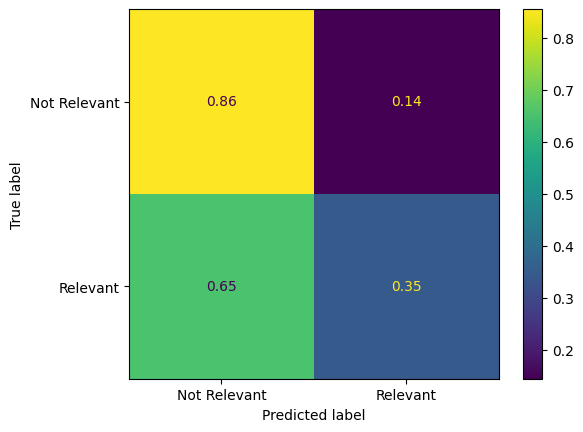

In [141]:
vect = CountVectorizer(preprocessor=clean) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)
# nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time logreg.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = logreg.predict(X_test_dtm) # make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))

disp = ConfusionMatrixDisplay(cm, display_labels=['Not Relevant','Relevant'])

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))
disp.plot()
plt.show()


CPU times: user 209 ms, sys: 0 ns, total: 209 ms
Wall time: 209 ms
Accuracy:  0.7367367367367368
ROC_AOC_Score:  0.6584385682402464


<Figure size 800x600 with 0 Axes>

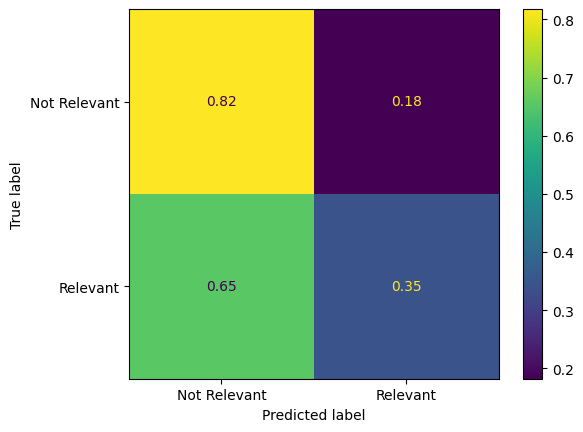

In [143]:
logreg = LogisticRegression(class_weight="balanced")
vect = CountVectorizer(preprocessor=clean,max_features=5000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)
# nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time logreg.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = logreg.predict(X_test_dtm) # make class predictions for X_test_dtm
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))

disp = ConfusionMatrixDisplay(cm, display_labels=['Not Relevant','Relevant'])

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))
disp.plot()
plt.show()


In [144]:
vect = CountVectorizer(preprocessor=clean) # instantiate a vectoriezer
X_kf = vect.fit_transform(X)# use it to extract features from training data
# transform testing data (using training data's features)
print(X_kf.shape)

(7991, 57775)


In [147]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lgr_accu_stratified = []
logreg = LogisticRegression(class_weight="balanced")

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X_kf[train_index], X_kf[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    logreg.fit(x_train_fold, y_train_fold)
    y_pred_prob = logreg.predict_proba(x_test_fold)[:, 1]
    lgr_accu_stratified.append(roc_auc_score(y_test_fold, y_pred_prob))

In [148]:
# Print the output.
import statistics
print('List of possible accuracy:', lgr_accu_stratified)
print('\nMaximum ROC That can be obtained from this model is:',
      max(lgr_accu_stratified)*100, '%')
print('\nMinimum ROC:',
      min(lgr_accu_stratified)*100, '%')
print('\nOverall ROC:',
      np.mean(lgr_accu_stratified)*100, '%')
print('\nStandard Deviation is:', statistics.stdev(lgr_accu_stratified))

List of possible accuracy: [0.6919107802709795, 0.6708228825004824, 0.6798802709713381, 0.7064575428216178, 0.6772300469483569]

Maximum ROC That can be obtained from this model is: 70.64575428216177 %

Minimum ROC: 67.08228825004824 %

Overall ROC: 68.52603047025549 %

Standard Deviation is: 0.014101601784471592


In [149]:
vect = CountVectorizer(preprocessor=clean,max_features=5000) # instantiate a vectoriezer
X_kf = vect.fit_transform(X)# use it to extract features from training data
# transform testing data (using training data's features)
print(X_kf.shape)

(7991, 5000)


In [155]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lgr_accu_stratified = []
logreg = LogisticRegression()
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X_kf[train_index], X_kf[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    logreg.fit(x_train_fold, y_train_fold)
    y_pred_prob = logreg.predict_proba(x_test_fold)[:, 1]
    lgr_accu_stratified.append(roc_auc_score(y_test_fold, y_pred_prob))

In [156]:
# Print the output.
import statistics
print('List of possible accuracy:', lgr_accu_stratified)
print('\nMaximum ROC That can be obtained from this model is:',
      max(lgr_accu_stratified)*100, '%')
print('\nMinimum ROC:',
      min(lgr_accu_stratified)*100, '%')
print('\nOverall ROC:',
      np.mean(lgr_accu_stratified)*100, '%')
print('\nStandard Deviation is:', statistics.stdev(lgr_accu_stratified))

List of possible accuracy: [0.6817811813848873, 0.6442670482560509, 0.6569018372028211, 0.6920112761806761, 0.655197547537891]

Maximum ROC That can be obtained from this model is: 69.20112761806762 %

Minimum ROC: 64.42670482560509 %

Overall ROC: 66.60317781124651 %

Standard Deviation is: 0.0199838551222786
